## Change code of Algorithm1 to subtract confidence bound of cost

In this notebook I see what changes when I subtract the confidence bound of estimated cost instead of adding it.
It should increase the incentive to observe features. This change is motivated by reconsidering what is correct in theory.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [134]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [135]:
TIME_POINTS = 10000
NUM_FEATURES = 4
N_ARMS = 5
# Beta parameter multiplies the reward achieved by the algorithm
BETA = 1

## Creating context vectors

In [136]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [137]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [138]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1, 2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1, 2, 3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [139]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [140]:
contexts, contexts.shape

(array([[4., 2., 2., 4.],
        [4., 2., 1., 3.],
        [4., 1., 1., 3.],
        ...,
        [2., 2., 1., 4.],
        [1., 2., 1., 4.],
        [2., 2., 1., 4.]]),
 (10000, 4))

### Visualizing context features

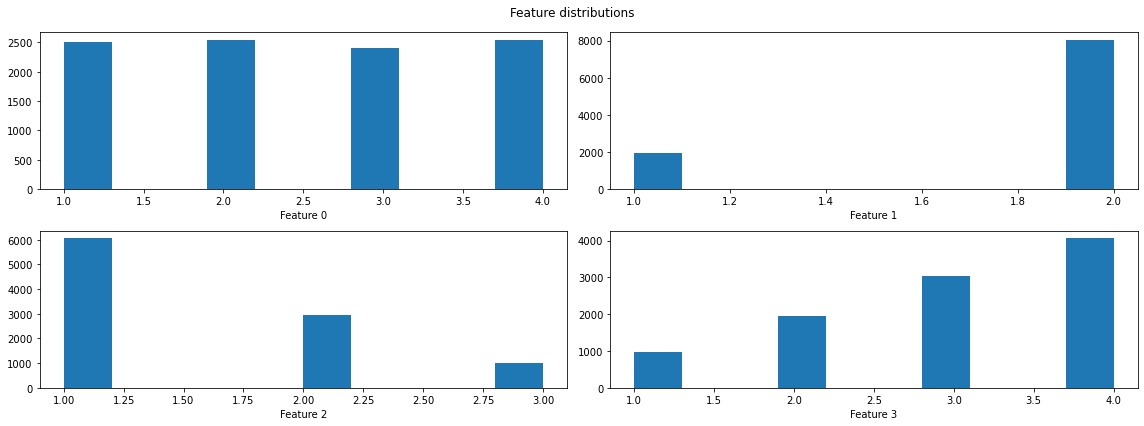

In [141]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [142]:
# Mean of gaussian distribution random in interval
interval_means_raw = np.array([np.random.uniform(0, 0.10, size=(NUM_FEATURES,)) for i in range(5)])

In [143]:
interval_means_raw

array([[0.06433543, 0.00585418, 0.02470971, 0.01538839],
       [0.02906733, 0.03288553, 0.04951968, 0.05201386],
       [0.0630098 , 0.03316521, 0.05320212, 0.09901173],
       [0.02106393, 0.01527058, 0.08425641, 0.04103656],
       [0.08468837, 0.0424689 , 0.00216849, 0.0374873 ]])

In [144]:
interval_means = interval_means_raw * BETA

In [145]:
# Fixed std
interval_stds = [[0.001]*NUM_FEATURES]*5

In [146]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

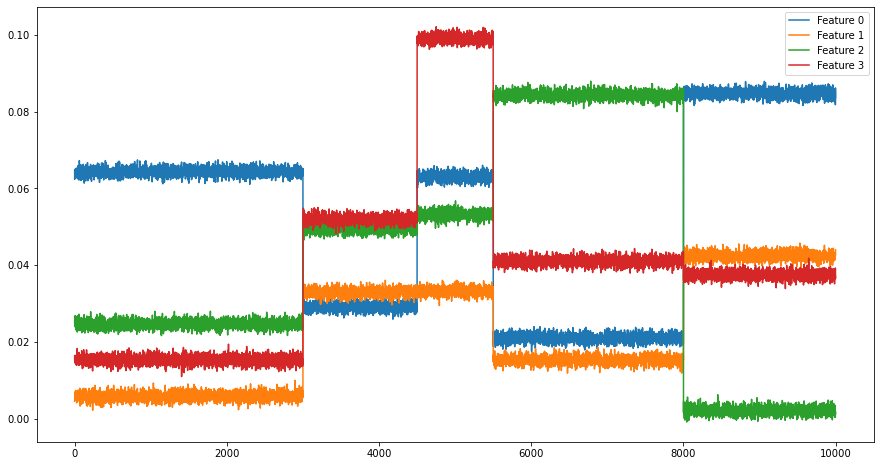

In [147]:
plot_costs(get_costs(), 10000)

In [148]:
costs_obj = get_costs()

In [149]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [150]:
costs_vector.shape

(10000, 4)

## Creating rewards

In [151]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [152]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,3500),
    slice(3500,5000),
    slice(5000,6500),
    slice(6500,8000),
    slice(8000,10000),
]

In [153]:
# old version
reward_config = {
    0: [
        0.28, 0.22 , 0.19 , 0.2 , 0.27 ,
    ],
    1: [
        0.24, 0.7 , 0.2 , 0.27 , 0.25 ,
    ],
    2: [
        0.22, 0.19 , 0.9 , 0.37 , 0.29 ,
    ],
    3: [
        0.36, 0.19 , 0.22 , 0.8 , 0.2 ,
    ],
    4: [
        0.26, 0.27 , 0.28 , 0.34 , 0.94 ,
    ],
    5: [
        0.77, 0.35 , 0.31 , 0.38 , 0.35 ,
    ],
    6: [
        0.2, 0.8 , 0.24 , 0.24 , 0.21 ,
    ],
    7: [
        0.2, 0.22 , 0.9 , 0.37 , 0.29 ,
    ],
}

In [154]:
# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        # Use p from config (reward range is config)
#         if arm == high_reward_arm:
#             reward_range = HIGH_REWARD_RANGE
#         else:
#             reward_range = LOW_REWARD_RANGE
        
#         p = np.random.uniform(reward_range[0], reward_range[1])

        p = reward_config[i][arm]

        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.28, mean reward=0.27   reward estimated by linear regression 0.27
  Arm 1: p=0.22, mean reward=0.24   reward estimated by linear regression 0.23
  Arm 2: p=0.19, mean reward=0.19   reward estimated by linear regression 0.19
  Arm 3: p=0.20, mean reward=0.20   reward estimated by linear regression 0.19
  Arm 4: p=0.27, mean reward=0.26   reward estimated by linear regression 0.26
Slice 1:
  Arm 0: p=0.24, mean reward=0.25   reward estimated by linear regression 0.24
  Arm 1: p=0.70, mean reward=0.71   reward estimated by linear regression 0.69
  Arm 2: p=0.20, mean reward=0.18   reward estimated by linear regression 0.18
  Arm 3: p=0.27, mean reward=0.26   reward estimated by linear regression 0.25
  Arm 4: p=0.25, mean reward=0.27   reward estimated by linear regression 0.27
Slice 2:
  Arm 0: p=0.22, mean reward=0.22   reward estimated by linear regression 0.21
  Arm 1: p=0.19, mean reward=0.17   reward estimated by linear regression 0.17
  Arm 2: p=0.90, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_49083/2779309452.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

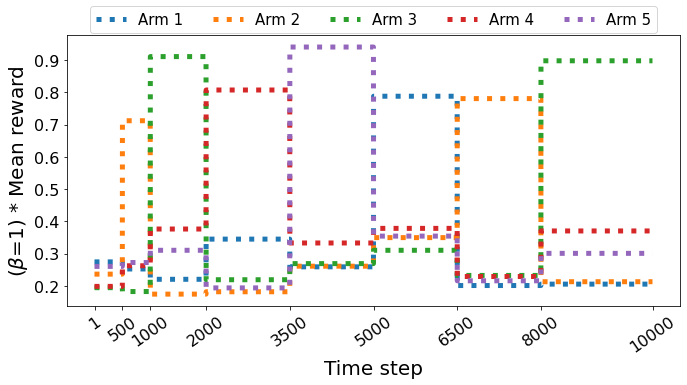

In [155]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(BETA * mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Plot reward - sum of feature costs

Min expected gain for arm 1: 0.004013248304766404
Min expected gain for arm 2: 0.006013248304766405
Min expected gain for arm 3: 0.014013248304766412
Min expected gain for arm 4: 0.06046667932907712
Min expected gain for arm 5: 0.024774358661449863


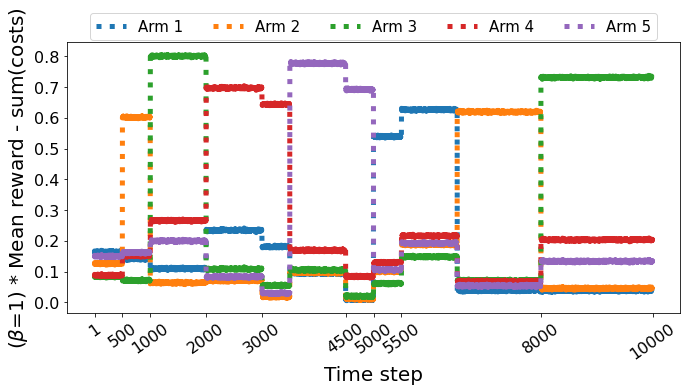

In [156]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 500, 1000, 2000, 3000, 4500, 5000, 5500, 8000, 10000]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [26]:
rewards.shape

(10000, 5)

In [27]:
costs_vector.shape

(10000, 4)

In [28]:
rewards

array([[1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [29]:
data = (contexts, rewards, costs_vector)

In [30]:
# import pickle

# with open('dataset/synthetic/synthetic_data.pickle', 'wb') as f:
#     pickle.dump(data, f)

## Testing algorithms on synthetic data

In [31]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
NUM_OF_TRIALS = 10000

In [33]:
NUM_REPETITIONS = 5

In [34]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3709.0
	Total reward: 3709.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3700.0
	Total reward: 3700.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3703.0
	Total reward: 3703.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3769.0
	Total reward: 3769.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3796.0
	Total reward: 3796.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3735.4


In [35]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.1, n_arms=rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.1)
Beta = 1
Total gain: 3934.0
	Total reward: 3934.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 3973.0
	Total reward: 3973.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4411.0
	Total reward: 4411.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4700.0
	Total reward: 4700.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4719.0
	Total reward: 4719.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4347.4


In [36]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=0.45,
    )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb
    
gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3900.0


In [37]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.6s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.6s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.7s
Average gain: 2327.7035697376323


In [38]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.03,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.8s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.7s
Average gain: 5395.703569737655


In [39]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=contexts, 
        number_of_actions=rewards.shape[1],
        max_no_red_context=contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.2,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            contexts[:NUM_OF_TRIALS],
            rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0013780593872070312 seconds
Trial 0, time 2022-04-25 19:48:45.420755
Trial 500, time 2022-04-25 19:48:51.586189
Trial 1000, time 2022-04-25 19:48:52.492742
Trial 1500, time 2022-04-25 19:48:53.628541
Trial 2000, time 2022-04-25 19:48:54.099740
Trial 2500, time 2022-04-25 19:48:54.455312
Trial 3000, time 2022-04-25 19:48:54.811499
Trial 3500, time 2022-04-25 19:48:55.226376
Trial 4000, time 2022-04-25 19:48:55.691880
Trial 4500, time 2022-04-25 19:48:56.158381
Trial 5000, time 2022-04-25 19:48:56.295363
Trial 5500, time 2022-04-25 19:48:56.926993
Trial 6000, time 2022-04-25 19:48:57.338881
Trial 6500, time 2022-04-25 19:48:57.479201
Trial 7000, time 2022-04-25 19:48:57.618310
Trial 7500, time 2022-04-25 19:48:57.858359
Trial 8000, time 2022-04-25 19:48:59.892911
Trial 8500, time 2022-04-25 19:49:00.643407
Trial 9000, time 2022-04-25 19:49:00.781465
Trial 9500, time 2022-04-25 19:49:00.917678
SimOOS (beta=1, delta=0.2)
Beta = 1
Total gain: 4090.988420382367
	Total reward: 4798.0
	

In [40]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=contexts, 
        number_of_actions=rewards.shape[1],
        max_no_red_context=contexts.shape[1],
        beta=BETA,
        delta=0.12,
        window_length=500,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            contexts[:NUM_OF_TRIALS],
            rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.003641843795776367 seconds
Round 0, time 2022-04-25 19:50:18.277882
Round 500, time 2022-04-25 19:50:58.817389
Round 1000, time 2022-04-25 19:51:43.399438
Round 1500, time 2022-04-25 19:52:28.755361
Round 2000, time 2022-04-25 19:53:14.106114
Round 2500, time 2022-04-25 19:54:00.068292
Round 3000, time 2022-04-25 19:54:45.645761
Round 3500, time 2022-04-25 19:55:30.406453
Round 4000, time 2022-04-25 19:56:19.032634
Round 4500, time 2022-04-25 19:57:09.238463
Round 5000, time 2022-04-25 19:57:55.502082
Round 5500, time 2022-04-25 19:58:41.309243
Round 6000, time 2022-04-25 19:59:26.216985
Round 6500, time 2022-04-25 20:00:11.891034
Round 7000, time 2022-04-25 20:00:58.439303
Round 7500, time 2022-04-25 20:01:43.831154
Round 8000, time 2022-04-25 20:02:28.860322
Round 8500, time 2022-04-25 20:03:13.725174
Round 9000, time 2022-04-25 20:03:58.931641
Round 9500, time 2022-04-25 20:04:44.111797
Algorithm1 (beta=1, delta=0.12, w=500)
Beta = 1
Total gain: 2348.7193066742875
	Total rewa

### Plot cumulative gain

In [41]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind % 7]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]
    plt.xticks( extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    
    plt.legend(prop={'size': 16});
#     plt.savefig('gain_synthetic.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

    
    plt.show();

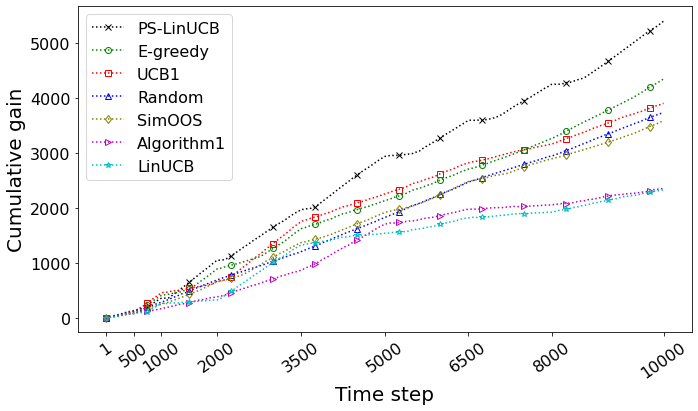

In [42]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


In [52]:
list(p_alg1.nus)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.

In [43]:
list(p_alg1.selected_context_SimOOS[:])

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 1.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 1.]),
 array([0., 1., 0., 0.]),
 array([0., 1., 0., 1.]),
 array([0., 1., 1., 0.]),
 array([0., 1., 1., 1.]),
 array([1., 0., 0., 0.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 1., 0.]),
 array([1., 0., 1., 1.]),
 array([1., 1., 0., 0.]),
 array([1., 1., 0., 1.]),
 array([1., 1., 1., 0.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 

In [44]:
list(p_alg1.costs)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([-0.93597739, -0.99422747, -0.97484982, -0.98472598]),
 array([-0.9358636 , -0.99413025, -0.97493751, -0.98476465]),
 array([-0.90867893, -0.96707196, -0.94802138, -0.9577837 ]),
 array([-0.8634768 , -0.92174907, -0.90274848, -0.91242088]),
 array([-0.82400589, -0.88224676, -0.86321933, -0.87294039]),
 array([-0.78911301, -0.84745842, -0.82842122, -0.83811297]),
 array([-0.75814856, -0.81638348, -0.79742757, -0.80705843]),
 array([-0.73022048, -0.7884741 , -0.76951029, -0.77917145]),
 array([-0.70501128, -0.76325765, -0.74440109, -0.75402599]),
 array([-0.68211295, -0.74

In [45]:
list(p_alg1.c_hats)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.06402261, 0.00577253, 0.02515018, 0.01527402]),
 array([0.0641364 , 0.00586975, 0.02506249, 0.01523535]),
 array([0.0642421 , 0.00584907, 0.02489964, 0.01513733]),
 array([0.064167  , 0.00589473, 0.02489532, 0.01522292]),
 array([0.06414543, 0.00590456, 0.02493199, 0.01521093]),
 array([0.06419518, 0.00584977, 0.02488696, 0.01519522]),
 array([0.06411978, 0.00588487, 0.02484077, 0.01520991]),
 array([0.06416621, 0.00591259, 0.02487639, 0.01521524]),
 array([0.06415033, 0.00590395, 0.02476052, 0.01513562]),
 array([0.06408341, 0.00584237, 0.02478105, 0.01509722]),
 arr

In [46]:
list(p_alg1.cost_conf_int)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([1.08775877, 1.08775877, 1.08775877, 1.08775877]),
 array([1.02554881, 1.02554881, 1.02554881, 1.02554881]),
 array([0.97292102, 0.97292102, 0.97292102, 0.97292102]),
 array([0.9276438, 0.9276438, 0.9276438, 0.9276438]),
 array([0.88815132, 0.88815132, 0.88815132, 0.88815132]),
 array([0.85330819, 0.85330819, 0.85330819, 0.85330819]),
 array([0.82226834, 0.82226834, 0.82226834, 0.82226834]),
 array([0.79438669, 0.79438669, 0.79438669, 0.79438669]),
 array([0.7691616, 0.7691616, 0.7691616, 0.7691616]),
 array([0.74619636, 0.74619636, 0.74619636, 0.74619636]),
 array([0.72

## Debugging

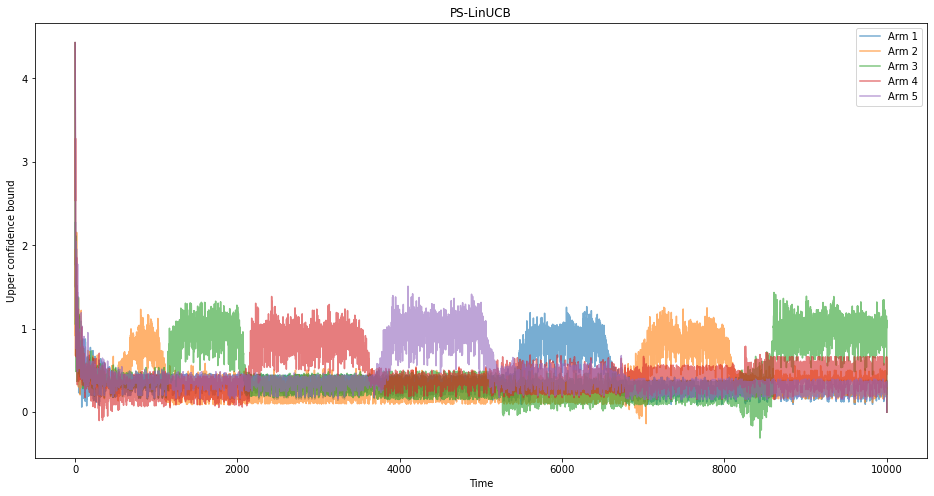

In [47]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ps_linucb.ucbs[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('PS-LinUCB');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

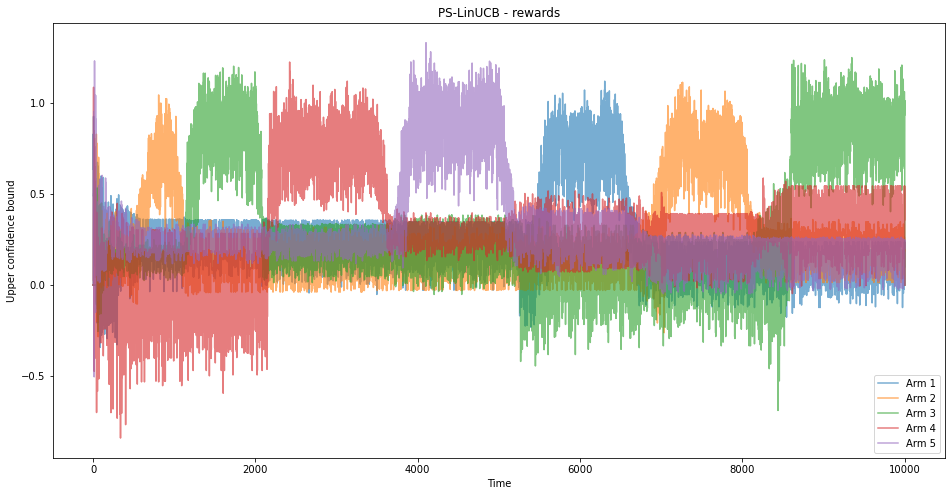

In [48]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ps_linucb.rewards[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('PS-LinUCB - rewards');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

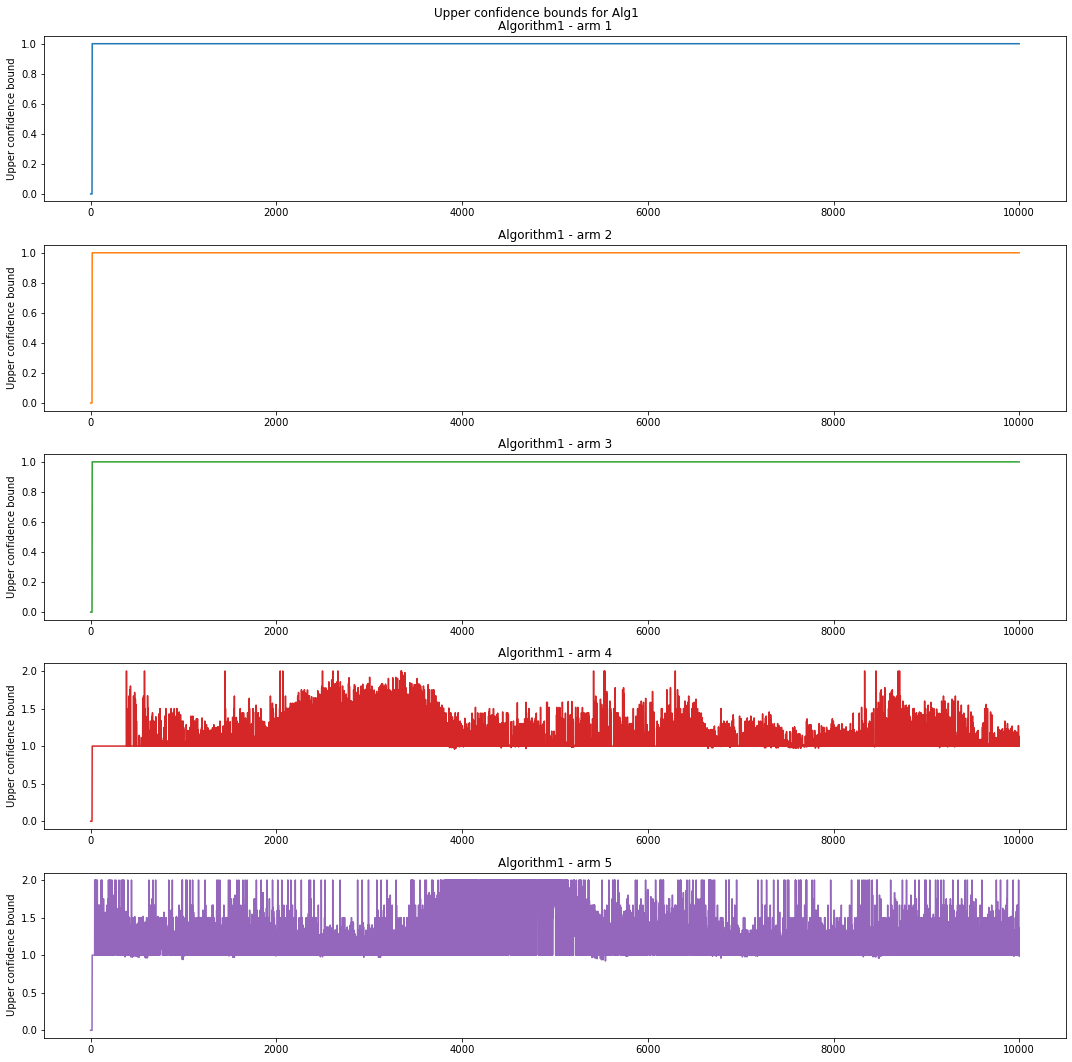

In [129]:


fig, ax = plt.subplots(5,1, figsize=(15, 15))
fig.suptitle('Upper confidence bounds for Alg1')
for i in range(5):
    ax[i].plot(p_alg1.ucbs[:NUM_OF_TRIALS, i], color=plt.cm.tab10(i));
    ax[i].set_title(f"Algorithm1 - arm {i+1}");
    ax[i].set_ylabel('Upper confidence bound');

plt.tight_layout();

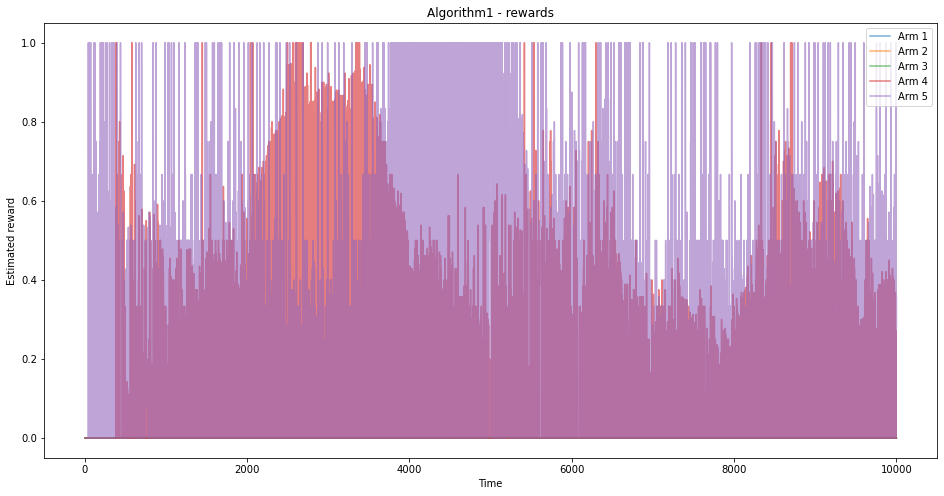

In [50]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.rewards[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - rewards');
ax.set_xlabel('Time');
ax.set_ylabel('Estimated reward');
plt.legend();

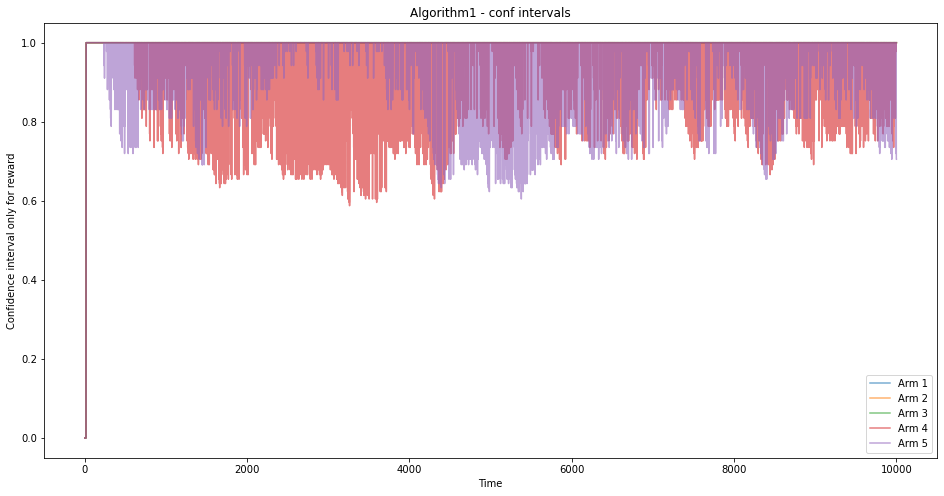

In [51]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.confidences[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - conf intervals');
ax.set_xlabel('Time');
ax.set_ylabel('Confidence interval only for reward');
plt.legend();

If we subtract the confidence interval the algorithm starts observing all the features throughout the experiment. The strange fact here is that it fails to adapt to changes and in general has a very poor performance. It seems that it is unable to identify best arm at all. I think something breaks in this scenario. I need to find what exactly is wrong.

I think my cost estimation is somehow broken, but I want to rule out other possible problems first. For this in the next experiment I am going to allow Algorithm1 to see the cost values exactly and see how it performs then.